# Gazetools Demo

In [1]:
import pkg_resources
import pyopencl as cl
import numpy as np
import pandas as pd
from scipy.ndimage import convolve1d as convolve1d_np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

from gazetools import *

#### Select an OpenCL device to compute on. 

In [2]:
platform = cl.get_platforms()
my_gpu_devices = platform[0].get_devices(device_type=cl.device_type.GPU)
print my_gpu_devices
ctx = cl.Context(devices=my_gpu_devices)

[<pyopencl.Device 'Iris Pro' on 'Apple' at 0x1024500>]


## Image Processing Tests

#### Load RGB test image

In [3]:
src1 = np.asarray(Image.open(pkg_resources.resource_filename("gazetools", "resources/images/PM5544_with_non-PAL_signals.png")))
print ("Source Dtype:",src1.dtype)
print ("Source Shape:",src1.shape)

('Source Dtype:', dtype('uint8'))
('Source Shape:', (576, 768, 3))


In [4]:
src2 = mpimg.imread(pkg_resources.resource_filename("gazetools", "resources/images/PM5544_with_non-PAL_signals.png"))
print ("Source Dtype:",src2.dtype)
print ("Source Shape:",src2.shape)

('Source Dtype:', dtype('float32'))
('Source Shape:', (576, 768, 3))


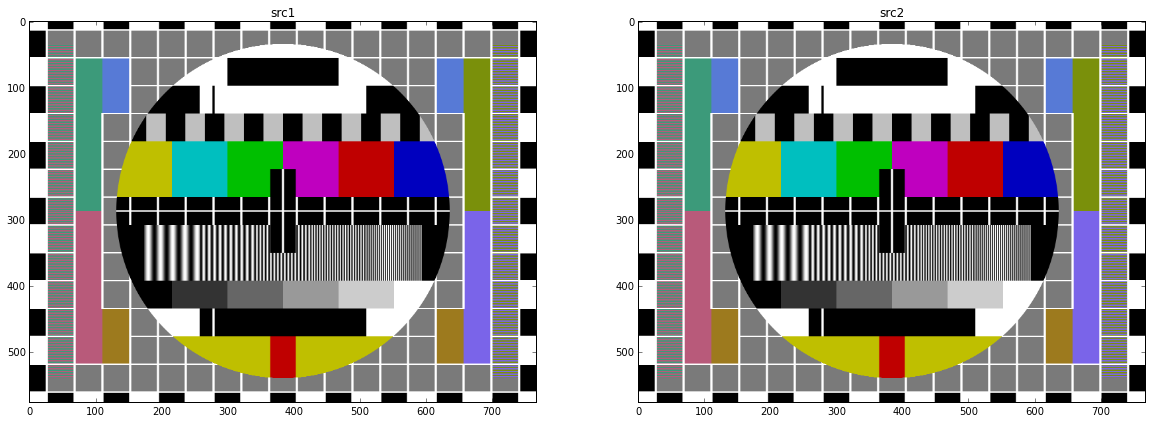

In [5]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(src1)
a.set_title("src1")
a=fig.add_subplot(1,2,2)
plt.imshow(src2)
a.set_title("src2")
plt.show()

#### Convert RGB test image to YCrCb

In [6]:
ycrcb1 = RGB2YCrCb(ctx, src1)
ycrcb2 = RGB2YCrCb(ctx, src2)

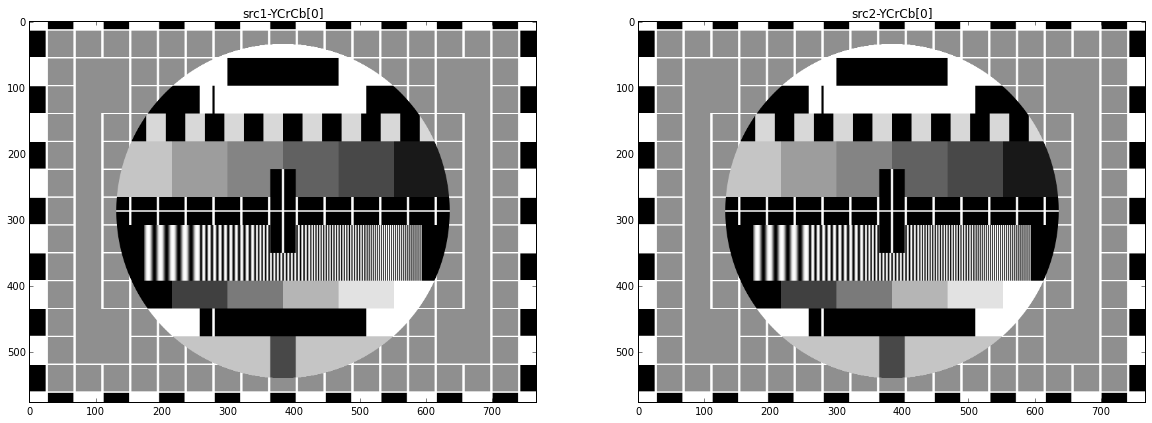

In [7]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,0], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[0]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,0], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[0]")
plt.show()

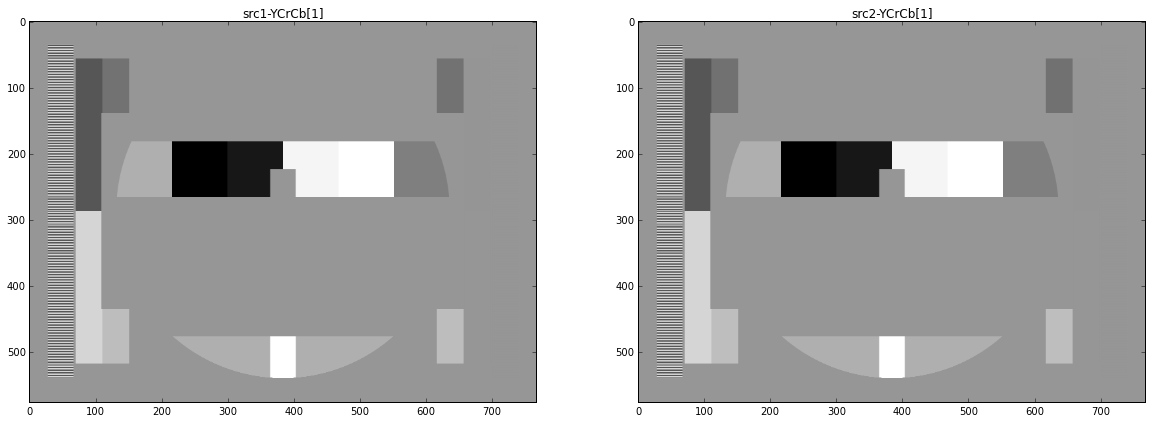

In [8]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,1], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[1]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,1], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[1]")
plt.show()

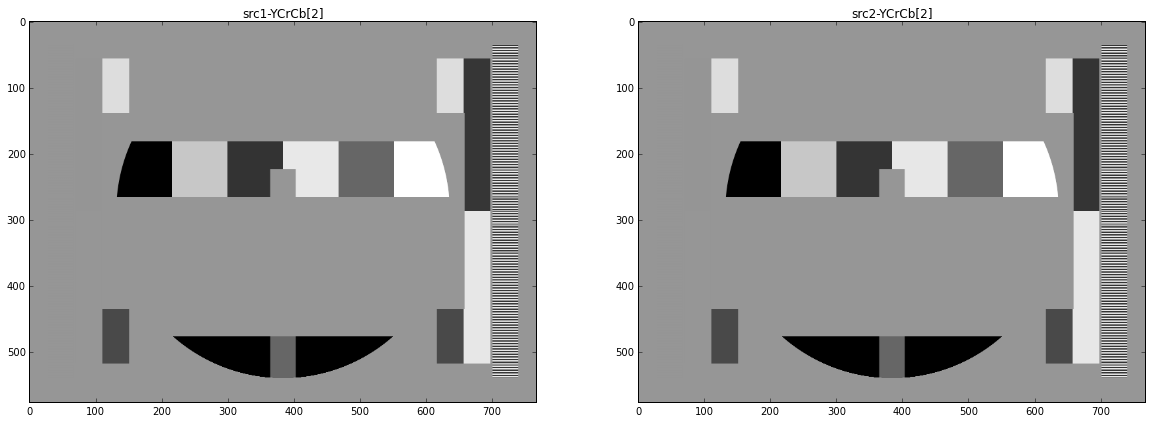

In [9]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(ycrcb1[:,:,2], cmap = cm.Greys_r)
a.set_title("src1-YCrCb[2]")
a=fig.add_subplot(1,2,2)
plt.imshow(ycrcb2[:,:,2], cmap = cm.Greys_r)
a.set_title("src2-YCrCb[2]")
plt.show()

#### Convert YCrCb test image back to RGB

In [10]:
rgb1 = YCrCb2RGB(ctx, ycrcb1)
rgb2 = YCrCb2RGB(ctx, ycrcb2)

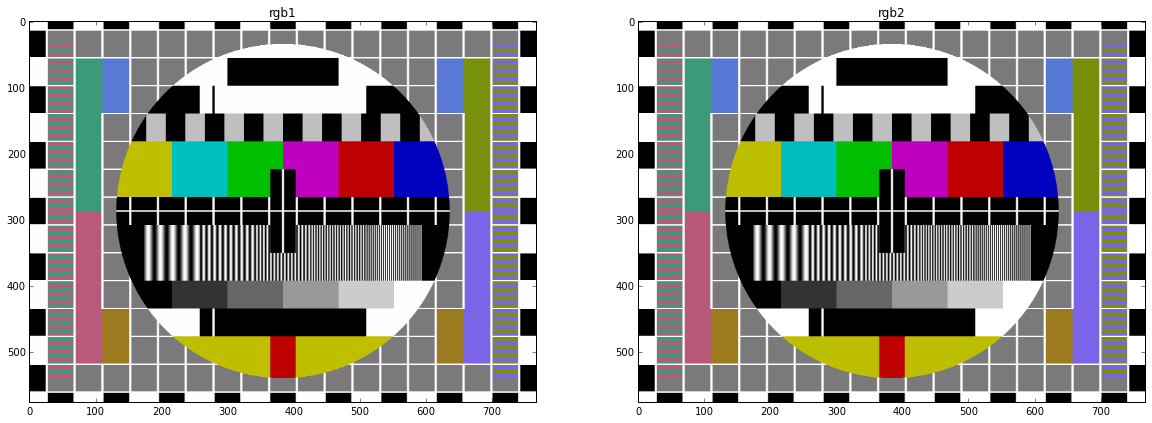

In [11]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(rgb1)
a.set_title("rgb1")
a=fig.add_subplot(1,2,2)
plt.imshow(rgb2)
a.set_title("rgb2")
plt.show()

## Visual Angle Tests

#### Constants

In [12]:
sx = 1680 # horizontal screen resolution (px)
sy = 1050 # vertical screen resolution (px)
sw = 473.76 # physical screen width (mm)
sh = 296.1 # physical screen height (mm)

#### Distance of observer (in 3D space) from point on screen

In [13]:
x = [0.0,0.0,1680.0/2.0,1680.0/2.0]
y = [0.0,1050.0/2.0,0.0,1050/2.0]
ez = [700.0]*4
ex = [0.0]*4
ey = [0.0]*4
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

array([ 753.67828369,  738.99395752,  715.48498535,  700.        ], dtype=float32)

In [14]:
x = [1680/2]
y = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
distance_2_point(ctx, x, y, sx, sy, sw, sh, ez, ex, ey)

array([ 700.], dtype=float32)

#### Distance between two points in degrees of visual angle relative to observer (in 3D space)

In [15]:
x1 = [0]
y1 = [1050/2]
x2 = [1680]
y2 = [1050/2]
ez = [700.0]
ex = [0.0]
ey = [0.0]
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

array([ 37.39164352], dtype=float32)

In [16]:
N = 1680 * 1050
x1 = np.tile(np.arange(1680),1050)
y1 = np.repeat(np.arange(1050), 1680)
x2 = [1680/2]*N
y2 = [1050/2]*N
ez = [700.0]*N
ex = [0.0]*N
ey = [0.0]*N
subtended_angle(ctx, x1, y1, x2, y2, sx, sy, sw, sh, ez, ex, ey)

array([ 21.75483131,  21.73794746,  21.72107315, ...,  21.69361496,
        21.71049881,  21.72738647], dtype=float32)

##### Calculate subtended angle around a constant point

In [17]:
sx = 1680
sy = 1050
sw = 473.76
sh = 296.1
ez = 700.0
x = np.tile(np.arange(2*sx),2*sy)
y = np.repeat(np.arange(2*sy),2*sx)
ecc = subtended_angle2(ctx, x, y, sx, sy, 2*sx, 2*sy, 2*sw, 2*sh, ez, 0, 0)
ecc_img = np.reshape(ecc, (2*sy,2*sx))

<matplotlib.colorbar.Colorbar instance at 0x11281acb0>

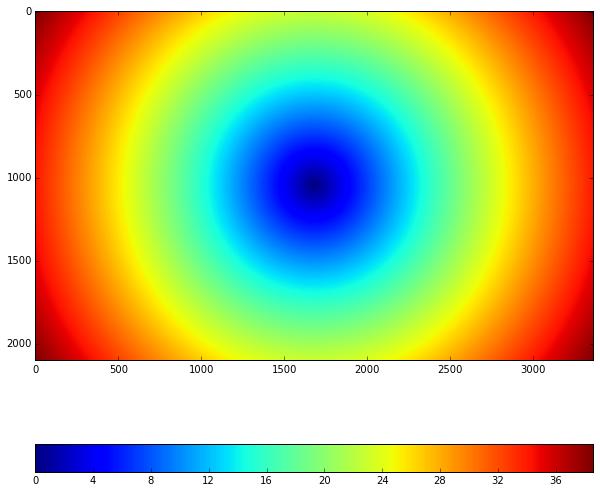

In [18]:
fig = plt.figure(figsize=(10,10))
a=fig.add_subplot(1,1,1)
plt.imshow(ecc_img)
plt.colorbar(orientation='horizontal')

## Filter Tests

##### Load test data

In [19]:
df=pd.read_csv(pkg_resources.resource_filename("gazetools","resources/data/smi.csv"))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3437 entries, 0 to 3436
Data columns (total 16 columns):
smi_time    3437 non-null int64
smi_type    3437 non-null object
smi_sxl     3437 non-null int64
smi_sxr     3437 non-null int64
smi_syl     3437 non-null int64
smi_syr     3437 non-null int64
smi_dxl     3437 non-null int64
smi_dxr     3437 non-null int64
smi_dyl     3437 non-null int64
smi_dyr     3437 non-null int64
smi_exl     3437 non-null float64
smi_exr     3437 non-null float64
smi_eyl     3437 non-null float64
smi_eyr     3437 non-null float64
smi_ezl     3437 non-null float64
smi_ezr     3437 non-null float64
dtypes: float64(6), int64(9), object(1)
memory usage: 456.5+ KB


#### Savitzky–Golay filter

##### Convolve smoothing filter with horizontal gaze coordinates

In [20]:
smooth = savgol_coeffs(11, 2, 0, 1.0/500.0) # window length 2, order 2, derivitive 0
smooth

array([-0.08391608,  0.02097902,  0.1025641 ,  0.16083916,  0.19580419,
        0.20745921,  0.19580419,  0.16083916,  0.1025641 ,  0.02097902,
       -0.08391608], dtype=float32)

In [21]:
x = np.array(df["smi_sxl"], dtype=np.float32) # horizontal gaze
x_np = convolve1d_np(x, smooth) # numpy reference
x_cl = convolve1d(ctx, x, smooth) # gazetools opencl implementation

In [22]:
print x[11:-11]

[  822.   821.   821. ...,  1265.  1267.  1269.]


In [23]:
print x_np[11:-11]

[  821.83917236   820.75756836   819.2074585  ...,  1264.44519043
  1266.95800781  1269.41723633]


In [24]:
print x_cl[11:-11]

[  821.83917236   820.75756836   819.2074585  ...,  1264.44519043
  1266.95800781  1269.41723633]


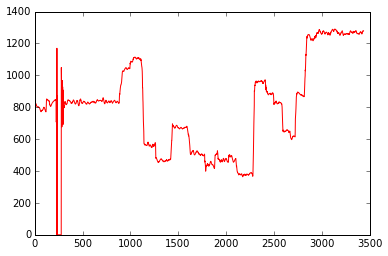

In [25]:
t = np.arange(x.shape[0])
plt.plot(t,x,'r-')

In [ ]:
plt.plot(t,x_np,'g-',t,x_cl,'b-')

In [ ]:
x_diff = x_cl - x_np
plt.plot(t,x_diff)

In [ ]:
plt.plot(t[:11],x_diff[:11],"r-",t[:11],x_diff[len(x_diff)-11:],"b-")

##### Convolve 1st derivitive filter with horizontal gaze coordinates

In [ ]:
velocity = savgol_coeffs(11, 2, 1, 1.0/500.0) # window length 2, order 2, derivitive 0
velocity

In [ ]:
v_np = convolve1d_np(x, velocity) # numpy reference
v_cl = convolve1d(ctx, x, velocity) # gazetools opencl implementation

In [ ]:
plt.plot(t,v_np,'g-',t,v_cl,'b-')

##### Convolve image with 3x3 gaussian kernel

In [ ]:
dest1s1 = convolve2d(ctx, src1, kernel_gaussian3x3)
dest2s1 = convolve2d(ctx, src1, kernel_gaussian3x3)
print ("Convolutions Equal:",np.array_equal(dest1s1,dest2s1))
print ("Convolve1 Dtype:",dest1s1.dtype)
print ("Convolve1 Shape:",dest1s1.shape)
print ("Convolve2 Dtype:",dest2s1.dtype)
print ("Convolve2 Shape:",dest2s1.shape)

In [ ]:
dest1s2 = convolve2d(ctx, src2, kernel_gaussian3x3)
dest2s2 = convolve2d(ctx, src2, kernel_gaussian3x3)
print ("Convolutions Equal:",np.array_equal(dest1s2,dest2s2))
print ("Convolve1 Dtype:",dest1s2.dtype)
print ("Convolve1 Shape:",dest1s2.shape)
print ("Convolve2 Dtype:",dest2s2.dtype)
print ("Convolve2 Shape:",dest2s2.shape)

In [ ]:
fig = plt.figure(figsize=(20,10))
a=fig.add_subplot(2,3,1)
plt.imshow(src1)
a.set_title("src1")
a=fig.add_subplot(2,3,2)
plt.imshow(dest1s1)
a.set_title("src1-blurred1")
a=fig.add_subplot(2,3,3)
plt.imshow(dest2s1)
a.set_title("src1-blurred2")
a=fig.add_subplot(2,3,4)
plt.imshow(src1)
a.set_title("src2")
a=fig.add_subplot(2,3,5)
plt.imshow(dest1s2)
a.set_title("src2-blurred1")
a=fig.add_subplot(2,3,6)
plt.imshow(dest2s2)
a.set_title("src2-blurred2")
plt.show()

##### Convolve image with 5x5 gaussian kernel

In [ ]:
dest3s1 = convolve2d(ctx, src1, kernel_gaussian5x5)
dest4s1 = convolve2d(ctx, src1, kernel_gaussian5x5)
print ("Convolutions Equal:",np.array_equal(dest3s1,dest4s1))
print ("Convolve1 Dtype:",dest3s1.dtype)
print ("Convolve1 Shape:",dest3s1.shape)
print ("Convolve2 Dtype:",dest4s1.dtype)
print ("Convolve2 Shape:",dest4s1.shape)

In [ ]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(dest3s1)
a.set_title("dest3s1")
a=fig.add_subplot(1,2,2)
plt.imshow(dest4s1)
a.set_title("dest4s1")
plt.show()

In [ ]:
dest3s2 = convolve2d(ctx, src2, kernel_gaussian5x5)
dest4s2 = convolve2d(ctx, src2, kernel_gaussian5x5)
print ("Convolutions Equal:",np.array_equal(dest3s1,dest4s1))
print ("Convolve1 Dtype:",dest3s2.dtype)
print ("Convolve1 Shape:",dest3s2.shape)
print ("Convolve2 Dtype:",dest4s2.dtype)
print ("Convolve2 Shape:",dest4s2.shape)

In [ ]:
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
plt.imshow(dest3s2)
a.set_title("dest3s2")
a=fig.add_subplot(1,2,2)
plt.imshow(dest4s2)
a.set_title("dest4s2")
plt.show()

##### Downsampling

In [ ]:
orig = src1
down1 = pyrDown(ctx, src1)
down2 = pyrDown(ctx, down1)
down3 = pyrDown(ctx, down2)
down4 = pyrDown(ctx, down3)
down5 = pyrDown(ctx, down4)

In [ ]:
combined = np.zeros((orig.shape[0]+orig.shape[0]/2,orig.shape[1],orig.shape[2]),dtype=orig.dtype)
combined[:orig.shape[0],:orig.shape[1],:] = orig
combined[orig.shape[0]:orig.shape[0]+down1.shape[0],:down1.shape[1],:] = down1
combined[orig.shape[0]+down2.shape[0]:orig.shape[0]+2*down2.shape[0],down1.shape[1]:down1.shape[1]+down2.shape[1]] = down2
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0],down1.shape[1]+down2.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]] = down3
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]+down4.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0]+2*down4.shape[0],down1.shape[1]+down2.shape[1]+down3.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]] = down4
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]+down4.shape[0]+down5.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0]+2*down4.shape[0]+2*down5.shape[0],down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]+down5.shape[1]] = down5

fig = plt.figure(figsize=(30,15))
plt.imshow(combined)
plt.show()

In [ ]:
orig = src2
down1 = pyrDown(ctx, src1)
down2 = pyrDown(ctx, down1)
down3 = pyrDown(ctx, down2)
down4 = pyrDown(ctx, down3)
down5 = pyrDown(ctx, down4)

In [ ]:
combined = np.zeros((orig.shape[0]+orig.shape[0]/2,orig.shape[1],orig.shape[2]),dtype=orig.dtype)
combined[:orig.shape[0],:orig.shape[1],:] = orig
combined[orig.shape[0]:orig.shape[0]+down1.shape[0],:down1.shape[1],:] = down1
combined[orig.shape[0]+down2.shape[0]:orig.shape[0]+2*down2.shape[0],down1.shape[1]:down1.shape[1]+down2.shape[1]] = down2
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0],down1.shape[1]+down2.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]] = down3
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]+down4.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0]+2*down4.shape[0],down1.shape[1]+down2.shape[1]+down3.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]] = down4
combined[orig.shape[0]+down2.shape[0]+down3.shape[0]+down4.shape[0]+down5.shape[0]:orig.shape[0]+2*down2.shape[0]+2*down3.shape[0]+2*down4.shape[0]+2*down5.shape[0],down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]:down1.shape[1]+down2.shape[1]+down3.shape[1]+down4.shape[1]+down5.shape[1]] = down5

fig = plt.figure(figsize=(30,15))
plt.imshow(combined)
plt.show()